### Load necessary libraries, if not installed then install.

In [1]:
# Clear environment
rm(list=ls())

# Set repository mirror
r <- getOption("repos")
r["CRAN"] <- "https://cran.cnr.berkeley.edu/"
options(repos = r)
rm(r)

# Load helper functions
source('./helper_functions.R')

# Install and load packages
use_package('bmp')
use_package('TDA')
use_package('doParallel')
use_package('doMC')
use_package('BiocManager')
use_package('ranger')
use_package('pROC')
BiocManager::install("EBImage")
library("EBImage")

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Bioconductor version 3.9 (BiocManager 1.30.4), R 3.6.0 (2019-04-26)
Installing package(s) 'EBImage'
installation path not writeable, unable to update packages: cluster, nlme
Update old packages: 'repr'


### Download GlaS@MICCAI'2015: Gland Segmentation Challenge Contest Dataset

In [7]:
download.file('https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip', './warwick.zip')
unzip('warwick.zip')

### Extract image labels and load images

In [3]:
dir_list <- list.dirs(path = ".", full.names = TRUE, recursive = TRUE)
img_path <- dir_list[length(dir_list)]
files <- list.files(img_path,pattern = "\\.bmp$")
meta <- tools::file_path_sans_ext(files)
annotate <- read.csv(paste(img_path,'/Grade.csv',sep=''))
ann <- data.frame(annotate)
ann$rank <- ifelse(ann$grade..GlaS.== ' benign', 0, 1) 
img_files <- files[which(!grepl('ann', files))]


### Compute persistence diagram and corresponding persistence intensity function in parallel

In [29]:
# Intitiate parallel environment
no_cores <- detectCores()
cl <- makeCluster(no_cores)
registerDoParallel(cl)

#Compute persistent homology and persistence intensity functions
pif_diag <- foreach(i=img_files, .packages=c('TDA', 'bmp', 'EBImage')) %dopar%{
        # Set filepath
        image_filepath <- paste(img_path,"/", i, sep = "")
        img_mat <- read.bmp(image_filepath)
        img_mat <- -1.2126*img_mat[,,1] + 0.7152*img_mat[,,2] + 0.0722*img_mat[,,3]
        # Downsample image by 50% to increase computational efficiency
        img_mat <- resize(img_mat, dim(img_mat)[1]/4)
        img_mat <- apply(img_mat, MARGIN = 2, FUN = function(X) (X - min(X))/diff(range(X)))
        #img_mat <- as.matrix(img_mat)
        # Generate persistence diagram
        tmp_diag <- gridDiag(FUNvalues=img_mat , sublevel=TRUE, printProgress=FALSE )
        # Compute persistence intensity function on persistence diagram
        tmp_pif <- pif(tmp_diag,n=10)
        # Return filename, 0-dimensional (connected comp), and 1 dimensional (cycles) persistence intensity function
        list(i, tmp_pif$dim_0, tmp_pif$dim_1)
        }
stopCluster(cl)

### Create dataframe of features

In [31]:
pif_list_0 <- lapply(pif_diag, function(x) x[[2]])
pif_upper_0 <- lapply(pif_list_0, function(x) x[upper.tri(x, diag=TRUE)])
pif_flat_0 <- lapply(pif_upper_0, function(x) as.vector(x))
pif_flat_0 <- matrix(unlist(pif_flat_0), ncol = length(pif_flat_0[[1]]), byrow = TRUE)

pif_list_1 <- lapply(pif_diag, function(x) x[[3]])
pif_upper_1 <- lapply(pif_list_1, function(x) x[upper.tri(x, diag=TRUE)])
pif_flat_1 <- lapply(pif_upper_1, function(x) as.vector(x))
pif_flat_1 <- matrix(unlist(pif_flat_1), ncol = length(pif_flat_1[[1]]), byrow = TRUE)    
pif_df <- data.frame(cbind(pif_flat_0, pif_flat_1))
pif_df$grade <- ann$rank

### Compute random forest

In [39]:
# Intitiate parallel environment
no_cores <- detectCores()
cl <- makeCluster(no_cores)
registerDoParallel(cl)

# Compute random forest model
model <- ranger(grade ~ ., data = pif_df, num.trees=500, importance='impurity', probability=TRUE)

stopCluster(cl)
print(model)

Ranger result

Call:
 ranger(grade ~ ., data = pif_df, num.trees = 500, importance = "impurity",      probability = TRUE) 

Type:                             Probability estimation 
Number of trees:                  500 
Sample size:                      165 
Number of independent variables:  110 
Mtry:                             10 
Target node size:                 10 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.1473168 


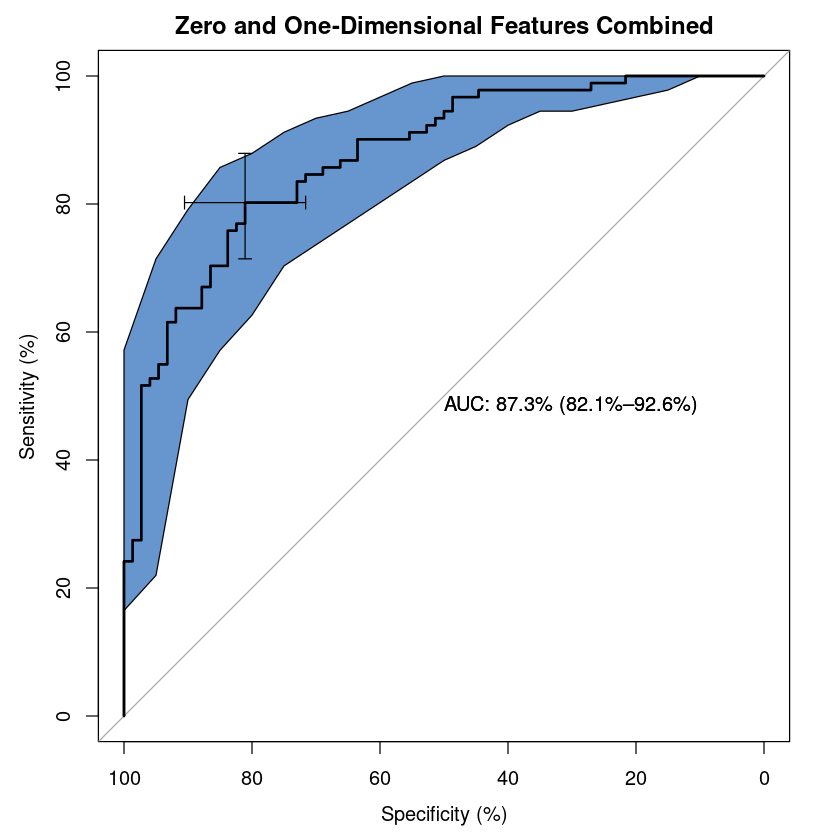

In [61]:
# Predict on RF model
pred <- predictions(model,ann$grade)

# Compute ROI ROC 
roc.roi <- plot.roc(ann$rank, pred[,2],
                   main = "Zero and One-Dimensional Features Combined", 
                   percent=TRUE,
                   ci = TRUE,                  # compute AUC (of AUC by default)
                   print.auc = TRUE)           # print the AUC (will contain the CI)
ci.roi <- ci.se(roc.roi,                         # CI of sensitivity
               specificities = seq(0, 100, 5)) # over a select set of specificities
plot(ci.roi, type = "shape", col = "#1c61b6AA")     # plot as a blue shape
plot(ci(roc.roi, of = "thresholds", thresholds = "best")) 
